# SVM and Logistic Regression Modeling

**Created by Phillip Efthimion, Scott Payne, Gino Varghese and John Blevins**

*MSDS 7331 Data Mining - Section 403 - Mini Project*

In this notebook a publicly available data set which is related to the popularities of online news sites will be analyzed. The online news popularity data set utilized in this analysis is publicly accessible from the UCI machine learning repository at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity.  The dataset can provide interesting insights into the popularity of online news articles based on article metadata such as word patterns, media content, message sentiment, day of publication and more. In this analysis, the ability to predict popularity is examined based on these attributes. As part of the analysis two different classification models will be considered: Logistic Regression and Support Vector Machines.  Of particular interest is a comparison between these two classification techniques and interpretation of the results.  The effectiveness of what makes either a good prediction algorithm will be based primarily on the performance accuracy as well as training time.  In addition the input parameters for fitting each model will be varied to observe the affect on the output.   

Python data tools will be used to tidy the data, fit the models and perform further exploratory analysis.  The following Python modules are required:
* Pandas
* Numpy
* Matplotlib
* Seaborn
* Sklearn
* Plotly
* Statsmodels.api
* Warnings
* Datetime

The shares attribute in the dataset represents the popularity value to be estimated.  This attribute is a continuous numeric type in the data set and must be recoded as a categorized response variable before performing the analysis.  This is done by establishing threshold for "popular" versus "non-popular" and generating a new result variable where share values are grouped as such.  The data will also be filtered based on articles having to do with technology.  This is due to the size of the original dataset and the amount of processing required to fit models for the dataset in it's entirety.  The population of interest is therefore limited to a these types of articles and any statistical results of the analysis limited as such.  In addition, attributes which don't provide useful explanetory functions in the anaylsys will be removed from the dataset.  An 80/20 training/testing split will be utilized for the model fitting and each model will be assessed for accuracy and performance.  Given the relatively small number of features in the data set a linear kernel specification will be used to fit each model.

In [1]:
# Import and Configure Required Modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
import datetime
warnings.simplefilter('ignore', DeprecationWarning)
plt.rcParams['figure.figsize']=(15,10)

# Read Online News Data
df = pd.read_csv('data/OnlineNewsPopularity.csv')

# Correct Column Names by Removing Leading Space
df.columns = df.columns.str.replace(' ', '')

# Rename Columns for Ease of Display
df = df.rename(columns={'weekday_is_monday': 'monday', 'weekday_is_tuesday': 'tuesday', 'weekday_is_wednesday': 'wednesday', 'weekday_is_thursday': 'thursday', 'weekday_is_friday': 'friday', 'weekday_is_saturday': 'saturday', 'weekday_is_sunday': 'sunday', 'is_weekend': 'weekend'})
df = df.rename(columns={'data_channel_is_lifestyle':'lifestyle', 'data_channel_is_entertainment':'entertainment', 'data_channel_is_bus':'business', 'data_channel_is_socmed':'social_media', 'data_channel_is_tech':'technology', 'data_channel_is_world':'world'})

# Encode a new "popular" column based on the # of shares 
# "popular" = 1 and "not popular" to 0.
df['popularity'] = pd.qcut(df['shares'].values, 2, labels=[0,1])
df.popularity = df.popularity.astype(np.int)

# Take a subset of the data related to Technology News Articles
dfsubset = df.loc[df['technology'] == 1]

# Reassign to New Variable and remove Columns which aren't needed
df_imputed = dfsubset
del df_imputed['url']
del df_imputed['shares']
del df_imputed['timedelta']
del df_imputed['lifestyle']
del df_imputed['entertainment']
del df_imputed['business']
del df_imputed['social_media']
del df_imputed['technology']
del df_imputed['world']

# Display Dataframe Structure
df_imputed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7346 entries, 4 to 39639
Data columns (total 53 columns):
n_tokens_title                  7346 non-null float64
n_tokens_content                7346 non-null float64
n_unique_tokens                 7346 non-null float64
n_non_stop_words                7346 non-null float64
n_non_stop_unique_tokens        7346 non-null float64
num_hrefs                       7346 non-null float64
num_self_hrefs                  7346 non-null float64
num_imgs                        7346 non-null float64
num_videos                      7346 non-null float64
average_token_length            7346 non-null float64
num_keywords                    7346 non-null float64
kw_min_min                      7346 non-null float64
kw_max_min                      7346 non-null float64
kw_avg_min                      7346 non-null float64
kw_min_max                      7346 non-null float64
kw_max_max                      7346 non-null float64
kw_avg_max                  

___
## Training and Testing Split
The binary popularity value will be predicted, where 0 represents non-popular articles while 1 represents popular articles. The remaining attributes will be included in the development of the prediction models.  An instance of the ShuffleSplit object is created from sklearn to setup the cross validation parameters.  The data will be split such that 80% of the data is put into a training dataset and the remaining 20% in a test dataset.

In [2]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'popularity' in df_imputed:
    y = df_imputed['popularity'].values # get the labels we want
    del df_imputed['popularity'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits, 3 iterations 
#    80% in training dataset and 20% for test
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


## Logistic Regression
A logistic regression model will be fit on the three iterations of the cross validation object (cv_object).  During each iteration the resultant accuracy, confusion matrix and training time will be calculated.

In [3]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    train_start_time = datetime.datetime.now()
    lr_clf.fit(X_train,y_train)  # train object
    train_end_time = datetime.datetime.now()
    train_time = train_end_time - train_start_time
        
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("Confusion matrix\n",conf)
    print("Training time", train_time)
    iter_num+=1
    
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.589795918367
Confusion matrix
 [[107 510]
 [ 93 760]]
Training time 0:00:00.339813
====Iteration 1  ====
accuracy 0.578911564626
Confusion matrix
 [[132 487]
 [132 719]]
Training time 0:00:00.362451
====Iteration 2  ====
accuracy 0.593197278912
Confusion matrix
 [[125 492]
 [106 747]]
Training time 0:00:00.188463


### Parameter Adjustment for Improving Accuracy
Attributes that don't provide any explanatory value have already been removed that would have affected the fitted model.  In addition the cost can be adjusted to improve accuracy.  The cost parameter tells the model optimization how much training data you want to avoid being misclassified. The large the cost, the optimization will choose smaller-margin hyperplane, the hyperplane does a good job in getting all the points in the training data classified. Similarly a small cost value will let the optimization to look for larger-margin separating hyperplane,in this approach the hyperplane ignore some points the training data will still be linearly separable.

## Resubmission change: 01
ipywidget has been fixed to be interactive 

In [23]:
# and here is an even shorter way of getting the accuracies for each training and test set
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object) # this also can help with parallelism
print(accuracies)

[ 0.6047619   0.61088435  0.61904762]


In [22]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None) # get object
    accuracies = cross_val_score(lr_clf,X,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

[ 0.60884354  0.61496599  0.61632653]


### Interpretting weights for Logistic Regression

The weights of the coefficients for logistic regressions are important for determining what attributes to include in the model. The logistic regression coefficients are used to predict the probability of an outcome, in this case, the popularity of the news article being "popular" or "not popular". A positive weight indicates that an increase in the attribute will increase the odds of the outcome being “popular”, while a negative weight indicates that an increase in the attribute will decrease the likelihood of the outcome being “popular”.  

In [6]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_imputed.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 

n_tokens_title has weight of -0.000230513359993
n_tokens_content has weight of 0.000457324156452
n_unique_tokens has weight of -1.24281070298e-05
n_non_stop_words has weight of -1.79000112727e-05
n_non_stop_unique_tokens has weight of -1.30225604209e-05
num_hrefs has weight of 0.000172850606323
num_self_hrefs has weight of -0.000260688617679
num_imgs has weight of -0.000353840388619
num_videos has weight of 3.81814986145e-05
average_token_length has weight of -8.16812455732e-05
num_keywords has weight of -0.000130859428251
kw_min_min has weight of -0.000812456409429
kw_max_min has weight of 4.03163680499e-05
kw_avg_min has weight of -0.000305076032072
kw_min_max has weight of -1.5685796155e-06
kw_max_max has weight of -1.73275456424e-06
kw_avg_max has weight of 4.44087161677e-07
kw_min_avg has weight of 3.88870779598e-05
kw_max_avg has weight of -4.8660801764e-05
kw_avg_avg has weight of 0.000590318530197
self_reference_min_shares has weight of 2.63357225987e-06
self_reference_max_shar

### Normalizing Features
Because the attributes do not all use the same measurement scale, the magnitude of the weights does not give meaningful insight into which attributes are most important for the model. The weights need to be scaled in the same way so that the magnitudes can be compared across all the features. The standard scaler will adjust the values of each attribute to be scaled by the average and standard deviation of each feature. The linear regression model will then be fit to the scaled values and the coefficient weights will be calculated based on that model.

In [7]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_imputed.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.622448979592
[[235 382]
 [173 680]]
kw_max_avg has weight of -0.176179345431
n_unique_tokens has weight of -0.149157420668
global_rate_positive_words has weight of -0.145327422116
num_self_hrefs has weight of -0.142798275052
avg_negative_polarity has weight of -0.116672934896
kw_max_max has weight of -0.114425795702
num_imgs has weight of -0.0943458264572
rate_negative_words has weight of -0.0843535025469
thursday has weight of -0.0666788171199
kw_max_min has weight of -0.0662201213735
global_sentiment_polarity has weight of -0.0650328341377
num_keywords has weight of -0.0602589302348
kw_min_max has weight of -0.0581155654326
avg_positive_polarity has weight of -0.0564354264318
LDA_01 has weight of -0.0548070197813
tuesday has weight of -0.0527012165208
n_non_stop_words has weight of -0.0520441782111
wednesday has weight of -0.0508874730783
n_tokens_title has weight of -0.0499112639255
self_reference_avg_sharess has weight of -0.0473299866312
average_token_length has weight

The weights of the regression coefficients are now scaled and the magnitudes can be compared against each other. The greatest magnitude coefficients are features that contain information about the maximum, average, and minimum number of shares for the post’s keyword (kw_max_avg, kw_min_min, kw_avg_avg). It makes sense that keywords with a higher minimum and average popularity would increase the probability of the outcome being popular. The number of links (num_hrefs) found within the article has a large positive magnitude, while the number of links to other articles on the same website(num_self_hrefs) has a large negative magnitude. It is possible that there is a collinearity problem with these features that should be explored further. The rate of positive words and rate of negative words have nearly identical magnitudes but in opposite directions, rate of positive words decreases the probability of popularity and rate of negative words increases it. The features that determine if the day is Saturday or the day is a weekend both have large positive magnitudes. Since these features are related, only including the feature indicating if the day is a weekend should not hurt the model. The last three impactful features are concerning the number of tokens, unique tokens, and nonstop unique tokens in the article. Greater number of tokens, or longer articles and nonstop unique tokens seem to increase the odds of popularity while total number of unique tokens is negative. This would indicate that longer articles with flourishes of colorful language can increase popularity while a large vocabulary in general can decrease popularity.

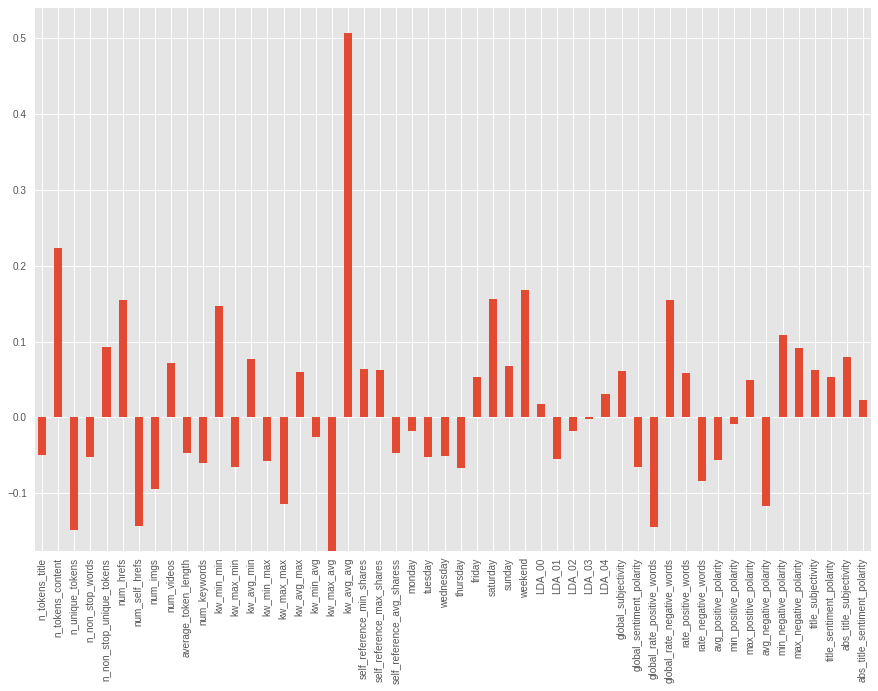

In [8]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(15,10)

weights = pd.Series(lr_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')
plt.show()

Based on the graph of the coefficient weights, a cut off of > 0.1 and < - 0.1 would include the highest magnitude features while removing some of the less impactful attributes. Using this threshold, the following features would be included in the model: n_tokens_content, n_unique_tokens, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, kw_min_min, kw_max_max, kw_max_avg, kw_avg_avg, weekend, global_rate_positive_words, global_rate_negative_words.

In [9]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

In [10]:
import plotly
from plotly import __version__
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Bar
# run at the start of every notebook


init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': df_imputed.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

If we use a 0.1 threshold from the weight plot, we see that n_tokens_content, n_unique_tokens, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, kw_min_min, kw_max_max, kw_max_avg, kw_avg_avg, self_reference_avg_sharess, saturday, weekend, global_rate_positive_words, global_rate_negative_words and rate_negative_words all have the most weight in predicting popularity.

In [11]:
Xnew = df_imputed[['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_sharess', 'saturday', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_avg_sharess', 'saturday', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)




If we use a 0.1 threshold from the weight plot, we see that n_tokens_content, n_unique_tokens, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, kw_min_min, kw_max_max, kw_max_avg, kw_avg_avg,  weekend, global_rate_positive_words, global_rate_negative_words and rate_negative_words all have the most weight in predicting popularity.

In [12]:
Xnew = df_imputed[['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_max', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

If we use a 0.1 threshold from the weight plot, we see that n_tokens_content, n_unique_tokens, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, kw_min_min, kw_max_avg, kw_avg_avg,  weekend, global_rate_positive_words, global_rate_negative_words and rate_negative_words all have the most weight in predicting popularity.

In [13]:
Xnew = df_imputed[['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

## Support Vector Machines
A support vector machine model will be fit on the three iterations of the cross validation object (cv_object).  During each iteration the resultant accuracy, confusion matrix and training time will be calculated.  

### Parameter Adjustment for Improved Accuracy
Either Linear or RBF kernel could have been used for this analysis however the linear kernel tends to perform better with a larger number of features.  RBF would be more appropriate for other applications like image classification.

## Resubmission change: 02
The model is built using the rbf kernel with costs of 0.5 and 1.  The accuracy of these fitted models will be compared to the linear model.

In [14]:
# rbf kernel run with cost = 0.5
from sklearn.svm import SVC

iter_num=0
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test)
    
    # train the model just as before
    svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
    train_start_time = datetime.datetime.now()
    svm_clf.fit(X_train_scaled, y_train)  # train object
    train_end_time = datetime.datetime.now()
    
    train_time = train_end_time - train_start_time
    
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print("====Iteration",iter_num," ====")
    print('Accuracy:', acc )
    print('Training time:', train_time)
    print('Confusion Matrix:', conf)
       
    iter_num+=1


====Iteration 0  ====
Accuracy: 0.640816326531
Training time: 0:00:04.564427
Confusion Matrix: [[166 422]
 [106 776]]
====Iteration 1  ====
Accuracy: 0.632653061224
Training time: 0:00:03.598928
Confusion Matrix: [[183 415]
 [125 747]]
====Iteration 2  ====
Accuracy: 0.637414965986
Training time: 0:00:05.139673
Confusion Matrix: [[187 415]
 [118 750]]


In [15]:
# rbf kernel run with cost = 1
from sklearn.svm import SVC

iter_num=0
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test)
    
    # train the model just as before
    svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
    train_start_time = datetime.datetime.now()
    svm_clf.fit(X_train_scaled, y_train)  # train object
    train_end_time = datetime.datetime.now()
    
    train_time = train_end_time - train_start_time
    
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print("====Iteration",iter_num," ====")
    print('Accuracy:', acc )
    print('Training time:', train_time)
    print('Confusion Matrix:', conf)
       
    iter_num+=1


====Iteration 0  ====
Accuracy: 0.641496598639
Training time: 0:00:03.520790
Confusion Matrix: [[204 395]
 [132 739]]
====Iteration 1  ====
Accuracy: 0.634013605442
Training time: 0:00:03.447429
Confusion Matrix: [[190 422]
 [116 742]]
====Iteration 2  ====
Accuracy: 0.637414965986
Training time: 0:00:03.827626
Confusion Matrix: [[194 388]
 [145 743]]


## Resubmission change: 03
After the first couple of runs with the RBF kernel, it was a reasonable first choice, however it does not perform well with higher dimensional spaces.  RBF can handle the case when the relations between class labels and attributes are nonlinear.  In this instance because the number of features in the data is very large and also because the data is composed primarily of consistent numeric data types the linear kernel model was chosen.


In [16]:
from sklearn.svm import SVC

iter_num=0
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    X_train_scaled = scl_obj.transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test)
    
    # train the model just as before
    svm_clf = SVC(C=1, kernel='linear', degree=3, gamma='auto') # get object
    #svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
    train_start_time = datetime.datetime.now()
    svm_clf.fit(X_train_scaled, y_train)  # train object
    train_end_time = datetime.datetime.now()
    
    train_time = train_end_time - train_start_time
    
    y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)

    print("====Iteration",iter_num," ====")
    print('Accuracy:', acc )
    print('Training time:', train_time)
    print('Confusion Matrix:', conf)
       
    iter_num+=1


====Iteration 0  ====
Accuracy: 0.616326530612
Training time: 0:00:06.862879
Confusion Matrix: [[176 422]
 [142 730]]
====Iteration 1  ====
Accuracy: 0.606802721088
Training time: 0:00:06.860668
Confusion Matrix: [[164 468]
 [110 728]]
====Iteration 2  ====
Accuracy: 0.632653061224
Training time: 0:00:07.651948
Confusion Matrix: [[189 387]
 [153 741]]


The accuracy of the support vectors for iteration zero is .6394. This means that 64% of the vectors are correctly classified out of a total of 1470. According to the confusion matrix, there were 162 predicted no that were actually no. There were 420 that were predicted yes, but were actually no. There were 110 that were predicted no, but were actually yes, and there were 778 that were predicted yes and were actually yes. Therefore, there were 940 predicted correctly and 530 predicted incorrectly.

The accuracy of the support vectors for iteration one is .6326. This means that 63% of the vectors are correctly classified out of a total of 1470. According to the confusion matrix, there were 174 predicted no that were actually no. There were 412 that were predicted yes, but were actually no. There were 128 that were predicted no, but were actually yes, and there were 756 that were predicted yes and were actually yes. Therefore, there were 930 predicted correctly and 540 predicted incorrectly.

The accuracy of the support vectors for iteration 2 is .6149. This means that 61% of the vectors are correctly classified out of a total of 1470. According to the confusion matrix, there were 163 predicted no that were actually no. There were 436 that were predicted yes, but were actually no. There were 130 that were predicted no, but were actually yes, and there were 741 that were predicted yes and were actually yes. Therefore, there were 904 predicted correctly and 566 predicted incorrectly.

The dimensions of the array of support vectors, the dimensions of the indices and the number of support vectors for each class can be displayed.

In [17]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(4639, 52)
(4639,)
[2311 2328]


The dimensions of the arrays of the support vectors are (4637, 52). The dimensions of the indices of the support vectors are around (4637, ) The number of support vectors for each class is [2309, 2328]. That is since 0 was classified as not popular and 1 was classified as popular, there are 2309 instances classified as not popular and 2328 instances classified as popular.

[[-0.01850249  0.11885268 -0.38861775 -0.06888462  0.2566705   0.11579837
  -0.08950762 -0.03475528  0.03518037  0.04009429 -0.06730189  0.21296823
  -0.04094926  0.05165455 -0.07881626 -0.158208    0.07832533 -0.06247573
  -0.34290254  0.74626316  0.0189098   0.01039957  0.01868818  0.03688428
  -0.05507149 -0.10590364 -0.05387897  0.09064487  0.09598185  0.06617644
   0.11979287 -0.00221718 -0.08762545 -0.00934715  0.00669696  0.04819673
   0.05247308 -0.1185571  -0.15955139  0.1707623   0.06962204 -0.10330384
  -0.06481901  0.00368799  0.08896021 -0.05264392  0.0373943   0.07674355
   0.00630529  0.02566983  0.07785119  0.03578556]]


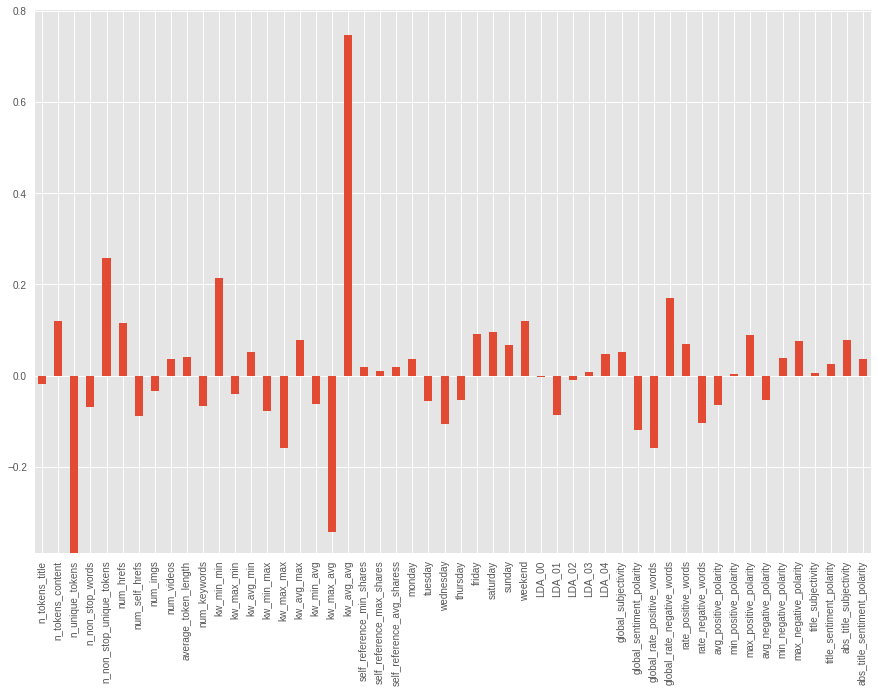

In [18]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')

Next we have the weights of each support vector. Plotting them, we can see which weights are the strongest and the weakest. Classifying coefficients. Kw_avg_avg had the highest coefficient, which means that it has the strongest weight. Other significant coefficients are kw_max_avg, n_unique_tokens, n_non_stop_unique_tokens_, global_rate_positive_words, and global_rate_negative_words. Some of the support vectors that have the smallest coefficients are kw_avg_min, self_reference_max_shares, LDA_02, and title_subjectivity.

In [19]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = df_imputed.loc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.loc[svm_clf.support_,:]
df_support['popularity'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
#print(df_imputed['popularity'])

#df_imputed.info()
df_imputed['popularity'] = y # also add it back in for the original data
#df_support.info()

/home/sam/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



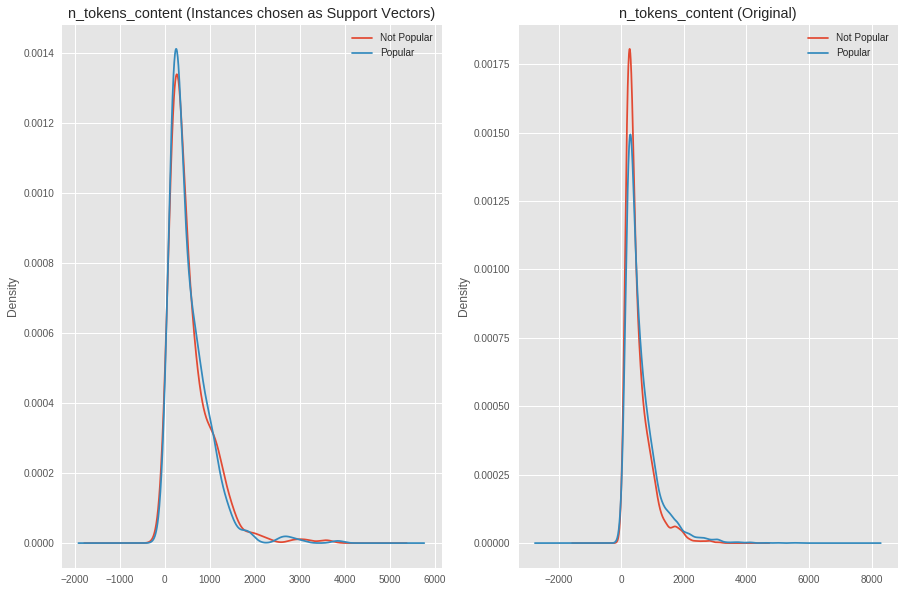

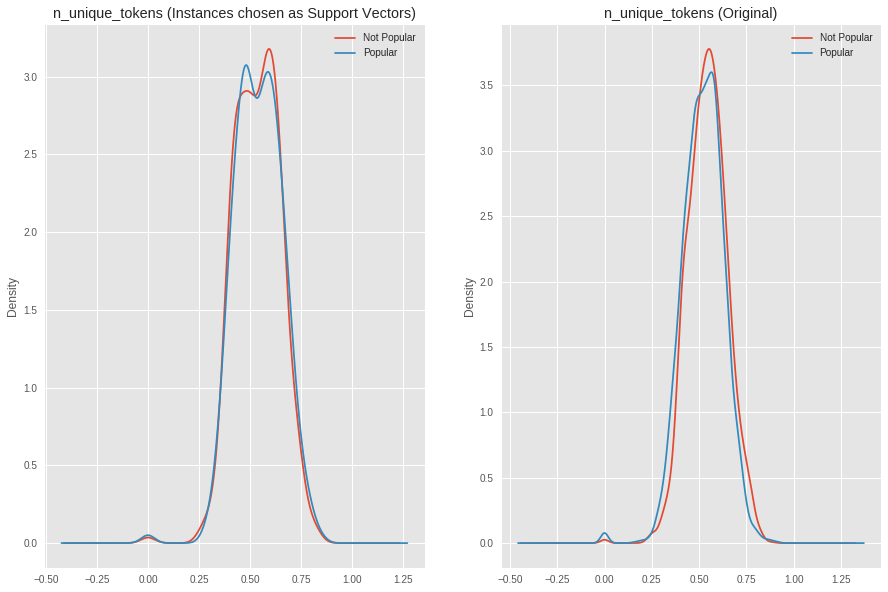

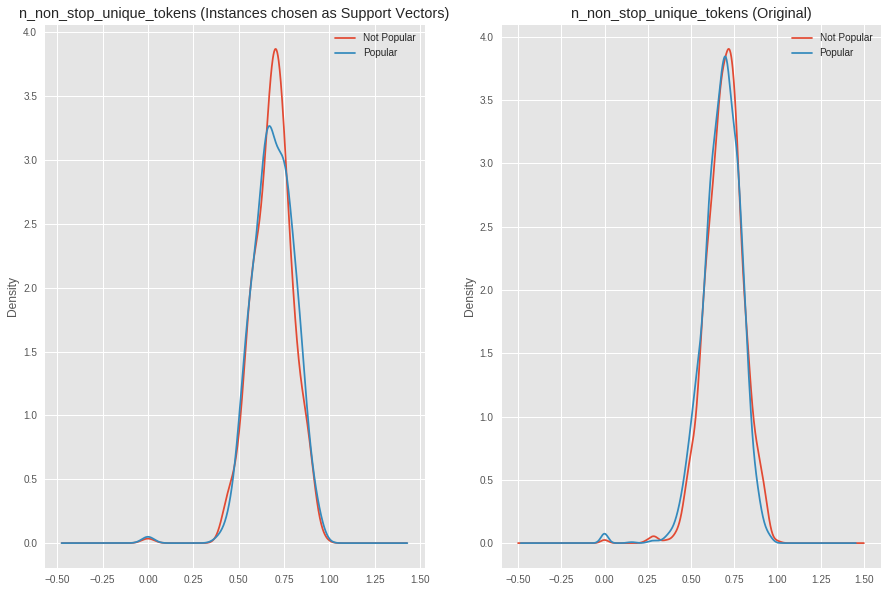

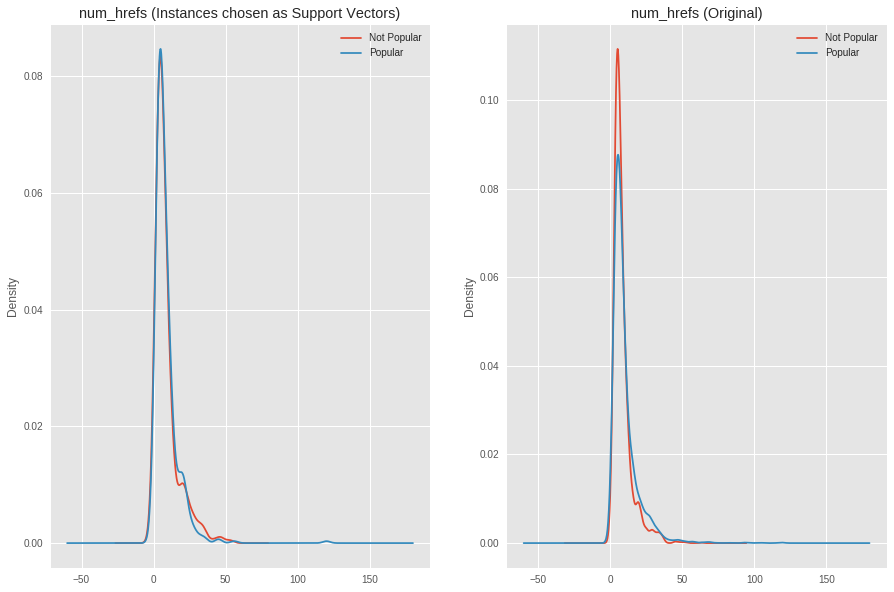

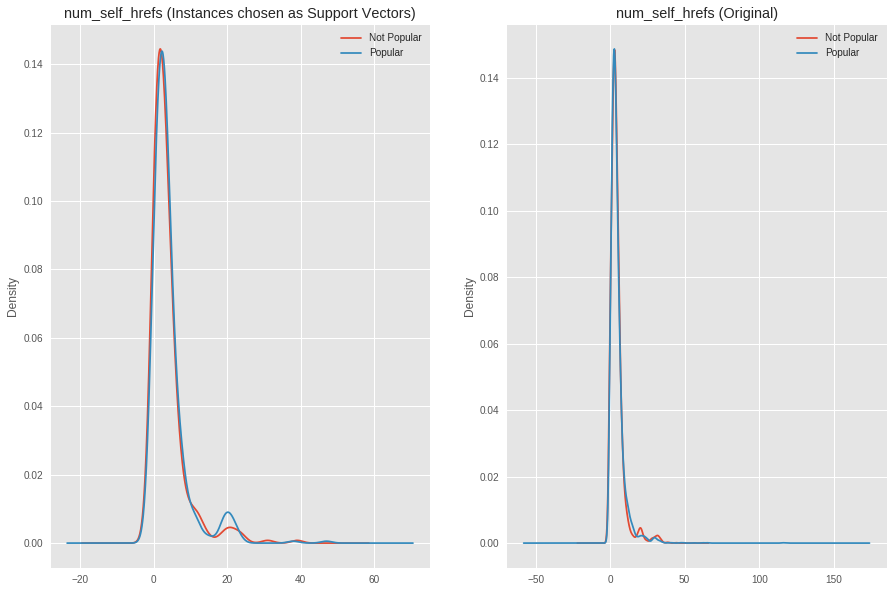

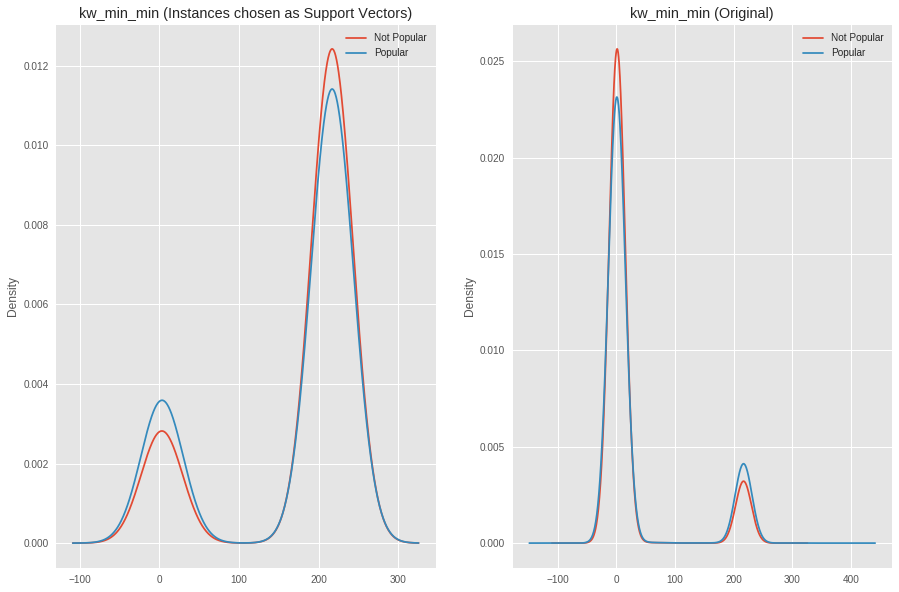

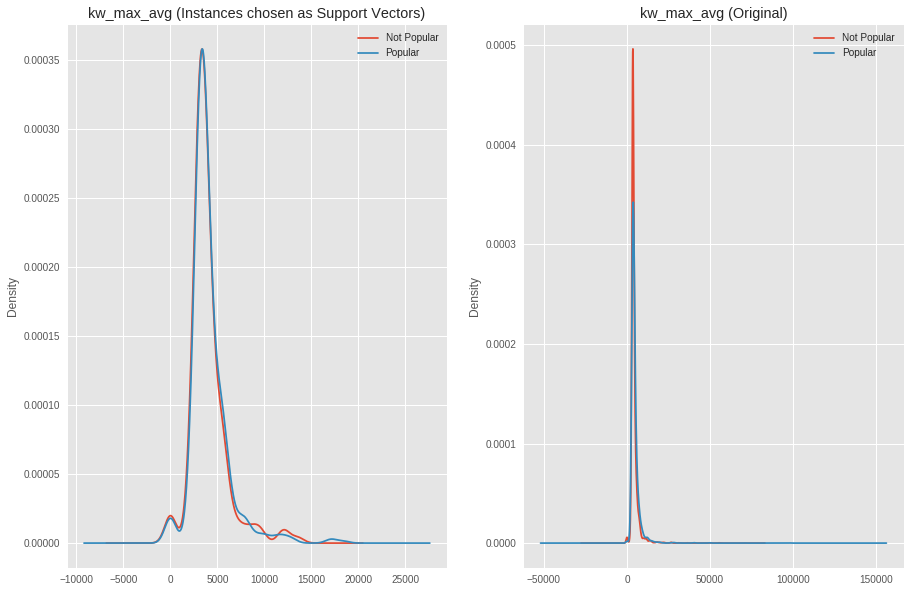

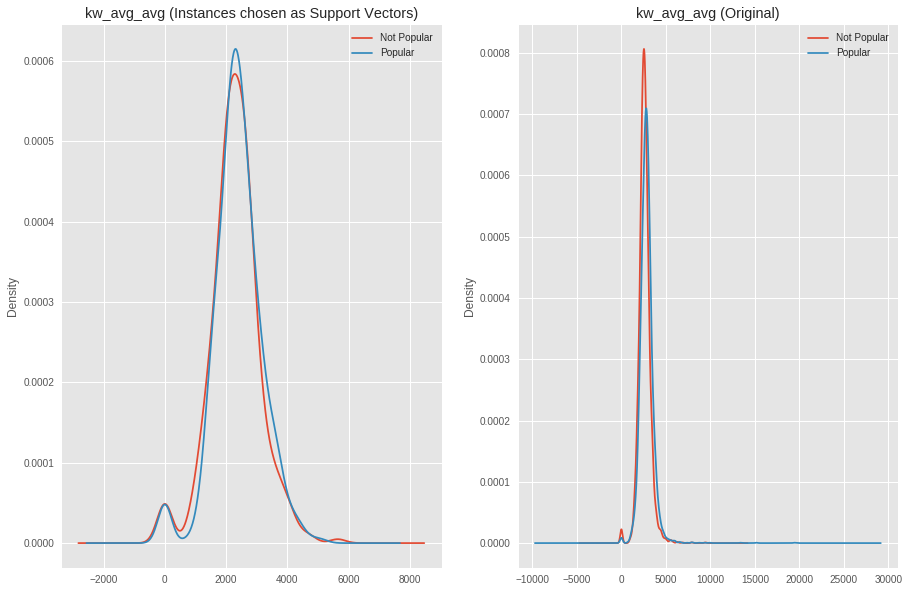

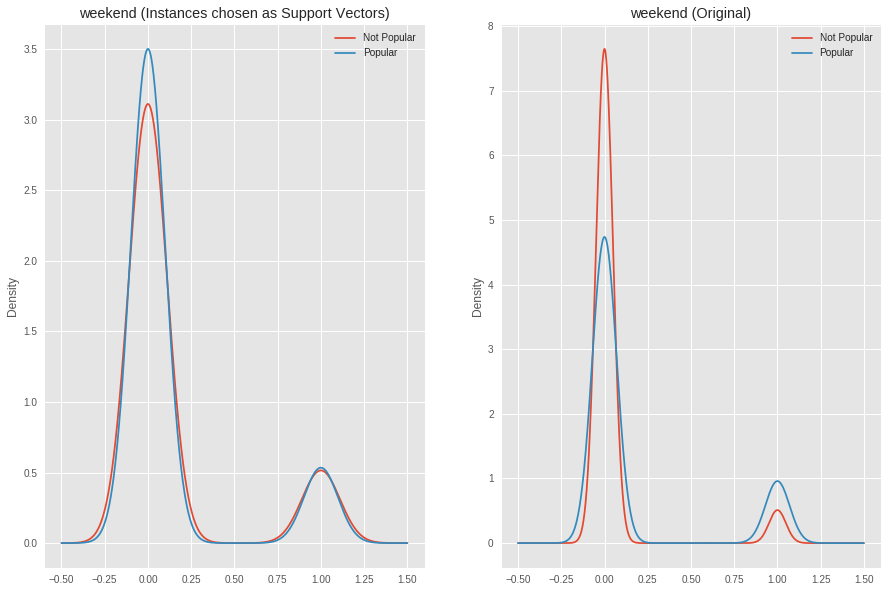

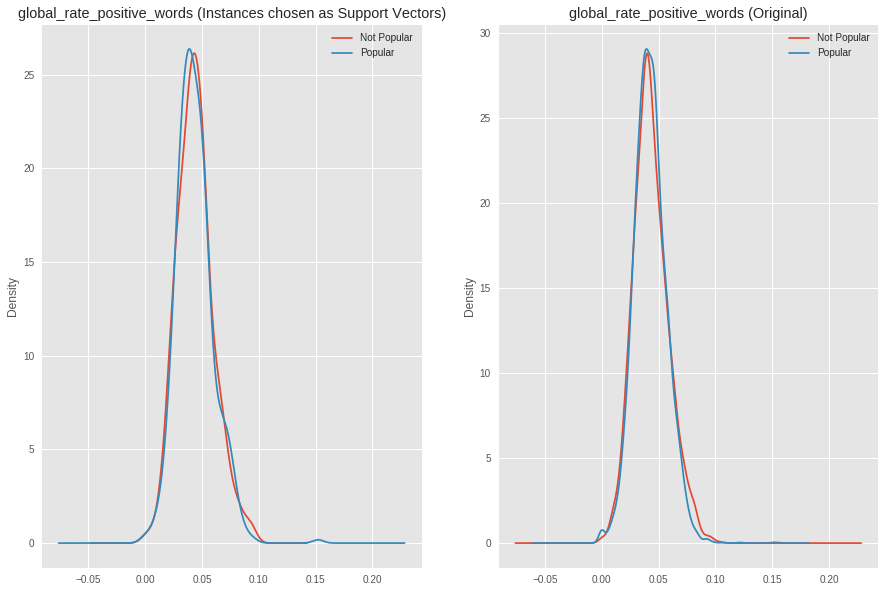

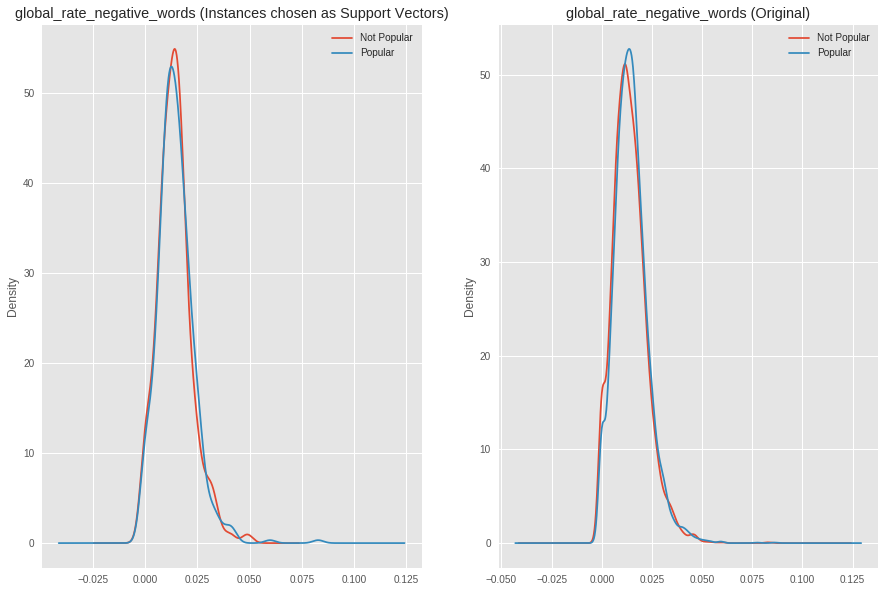

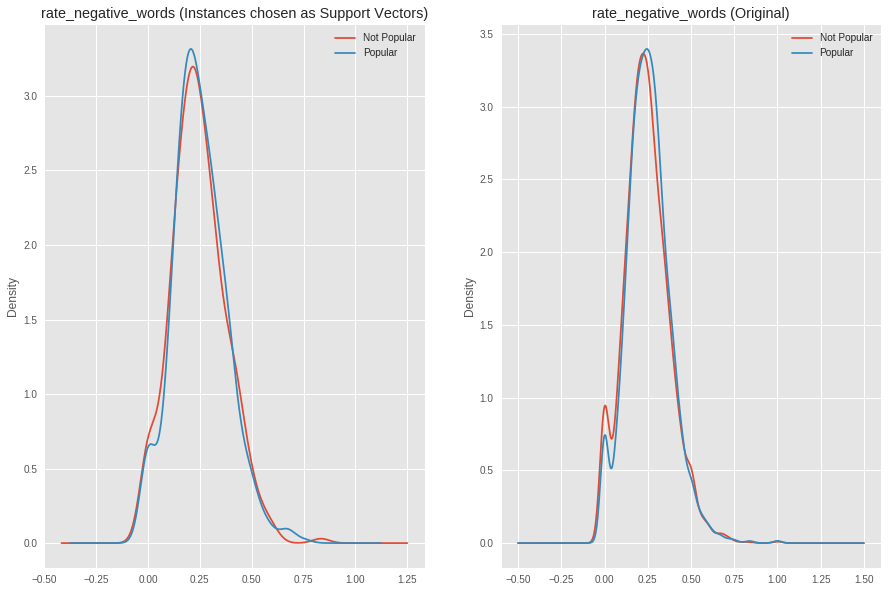

In [20]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['popularity'])
df_grouped = df_imputed.groupby(['popularity'])

# plot KDE of Different variables
vars_to_plot = ['n_tokens_content', 'n_unique_tokens', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'kw_min_min', 'kw_max_avg', 'kw_avg_avg', 'weekend', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_negative_words']

for v in vars_to_plot:
    plt.figure(figsize=(15,10))
    #plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Not Popular','Popular'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Not Popular','Popular'])
    plt.title(v+' (Original)')



When looking at the density graphs we can see which attributes support vectors are more or less popular than the original. For example we can see in n_tokens_content that the instances chosen as support vectors for popular instances were about the same as the original data. However, there were less non popular instances. 

In terms of coefficients with larger weights, the instances chosen as support vectors for n_unique_tokens was less dense than the original data, but roughly the same distribution. This is also the same for n_non_stop_unique_tokens. For kw_avg_avg, this is also true but also there are more popular instances chosen in the support vector than non popular. The opposite is true in the original data. This is also the case for kw_max_avg.

We did not have to use stochastic gradient descent on our data and therefore did not have to take any subsamples of the data.

## Advantages/Disadvantages of Each Model
The support vector model offers slightly better performance accuracy than the logistric regression model.  On average the accuracy is around 1% better for SVM with the dataset under analysis.  This is expected since SVM is typically expected to perform only marginally better than logistic regression with a smaller number of dimensions.  Because logistic regression depends much more on probability functions versus the use of predictor attributes to determine a response variable this is sufficient.  For an analysis which has hundreds or even thousands of explanatory veriables SVM would likely provide significantly more accuracy.  In terms of training time the support vector model does take significantly longer to complete.  On average it takes around 34 times longer to train the SVM model.  This is expected due to the calculation times invovled with calcualting the hyperplanes on multiple dimensions.  Logistic regression simply tries to determine a probability for a logistic function of a linear combination of the attributes which takes much fewer iterations.  

## Sources
https://www.quora.com/Machine-Learning/How-does-one-decide-on-which-kernel-to-choose-for-an-SVM-RBF-vs-linear-vs-poly-kernel
http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf